In [1]:
import gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import rlutils

In [2]:
class Discriminator(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        return torch.sigmoid(self.fc2(x))


In [8]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        
'''PPO算法，采用截断方式'''
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_rl, lmbda, epochs, eps, gamma, device) -> None:
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.critic = ValueNet(state_dim, hidden_dim)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_rl)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def compute_advantage(gamma, lmbda, td_delta):
        td_delta = td_delta.detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_delta[::-1]:
            advantage = gamma * lmbda * advantage + delta
            advantage_list.append(advantage)
            advantage_list.reverse()
        return torch.tensor(advantage_list, dtype=torch.float)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        td_targe = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_targe - self.critic(states)
        advantage = rlutils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_targe.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            


In [20]:
class GAIL:
    def __init__(self, agent, state_dim, action_dim, hidden_dim, lr_d, device) -> None:
        self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(),lr=lr_d)
        self.agent = agent
        self.device = device
    
    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones):
        expert_states = torch.tensor(expert_s, dtype=torch.float).to(self.device)
        expert_actions = torch.tensor(expert_a, dtype=torch.int64).to(self.device)

        agent_states = torch.tensor(agent_s, dtype=torch.float).to(self.device)
        agent_actions = torch.tensor(agent_a, dtype=torch.int64).to(self.device)

        expert_actions = F.one_hot(expert_actions, num_classes=2).float()
        agent_actions = F.one_hot(agent_actions, num_classes=2).float()

        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)
        discriminatior_loss = nn.BCELoss()(agent_prob, torch.ones_like(agent_prob)) + nn.BCELoss()(expert_prob, torch.zeros_like(expert_prob))

        self.discriminator_optimizer.zero_grad()
        discriminatior_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        transition_dict = {'states': agent_s, 'actions': agent_a, 'rewards': rewards, 'next_states': next_s, 'dones': dones}
        self.agent.update(transition_dict)

In [25]:
# agent = torch.load('best_agent_ppo')

actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

lr_d = 1e-3
env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

c:\Users\guimengke\Anaconda\envs\RL\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [22]:
# 生成专家数据
def sample_expert_data(n_episodes):
    states = []
    actions = []
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            state = next_state
    return np.array(states), np.array(actions)


env.seed(0)
torch.manual_seed(0)
random.seed(0)
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 30  # 采样30个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

In [26]:



gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d, device)
batch_size = 64
n_episode = 500
return_list = []

with tqdm(total=n_episode, desc='进度条') as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)

        gail.learn(expert_s, expert_a, state_list, action_list, next_state_list, done_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)



进度条: 100%|██████████| 500/500 [00:36<00:00, 13.80it/s, return=200.000]


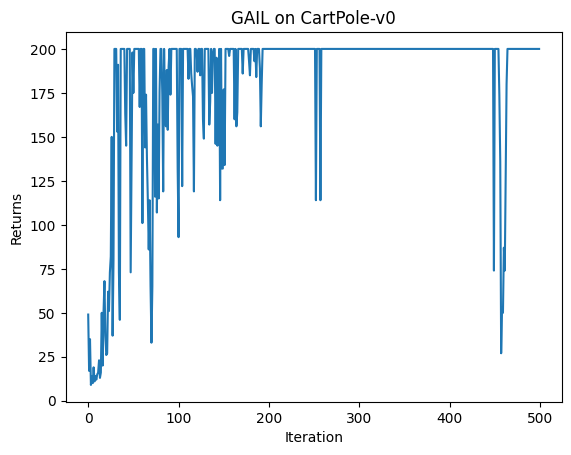

In [27]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Iteration')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()

In [31]:
state = env.reset()
total_reward = 0
done = False
while not done:
    env.render()
    action = gail.agent.take_action(state)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.close()

200.0
